# LuxonisDatasetFormat - testing embeddings methods - Weaviate

This notebook is a part of the LuxonisDatasetFormat project. It is used to test the embeddings methods.
Specifically, it is used to test the embeddings method using the Weaviatea vector database.

For local testing, you'll need a local instance of Weaviate running. One easy way to do this is through docker using this command:
```bash
docker run -d --name weaviate -p 8080:8080 -p 50051:50051 semitechnologies/weaviate:latest
```

In [1]:
import os
import uuid

import onnxruntime
import torch
import torch.onnx
import torchvision
from matplotlib import pyplot as plt
from utils.data_utils import load_mnist_data
from utils.torch_utils import (
    export_model_onnx,
    extract_embeddings_onnx,
    extract_embeddings_torch,
    load_embeddings,
    load_model_resnet50,
    save_embeddings,
)

from luxonis_ml.data import (
    LuxonisDataset,
    LuxonisLoader,
)
from luxonis_ml.embeddings.utils.embedding import extract_embeddings
from luxonis_ml.embeddings.utils.ldf import generate_embeddings
from luxonis_ml.embeddings.utils.model import (
    extend_output_onnx,
    load_model_onnx,
    save_model_onnx,
)
from luxonis_ml.embeddings.utils.weaviate import WeaviateAPI
from luxonis_ml.utils import LuxonisFileSystem

## Pytorch examples

This section shows how to extract embeddings from a pre-trained model using Pytorch.
Specifically, we use the ResNet-50 model and the MNIST dataset, which gets loaded from the torchvision library into a torch DataLoader.

In [2]:
# Load the data
data_loader = load_mnist_data(save_path="./data/mnist", num_samples=640, batch_size=64)

In [3]:
# Load the model
model = load_model_resnet50(discard_last_layer=True)

In [4]:
# Extract embeddings from the dataset
embeddings, labels = extract_embeddings_torch(model, data_loader)

In [5]:
save_embeddings(embeddings, labels, "./data/")

## ONNX models and Weaviate

This section shows how to convert the Pytorch model to ONNX and how to use the ONNX model to extract embeddings from the MNIST dataset and store them in Weaviate.

In [6]:
# Load the data
data_loader = load_mnist_data(save_path="./data/mnist", num_samples=640, batch_size=64)

Here we load the ResNet-50 model, convert it to ONNX, and expose the specific layer that we want to use for embeddings (here named "/Flatten_output_0"). 

To see the graph and the names of the layers, we use the Netron tool (https://netron.app/).

You can set overwrite parameter in the extend_output_onnx function to True to expose the second-to-last layer of the model as the output layer and rename it.

In [7]:
# Load the model
model = load_model_resnet50(discard_last_layer=False)

# Export the model to ONNX
export_model_onnx(model, model_path_out="./data/resnet50.onnx")

# Load the ONNX model
onnx_model = load_model_onnx(model_path="./data/resnet50.onnx")

# Extend the ONNX model with an intermediate output layer
onnx_model = extend_output_onnx(
    onnx_model, intermediate_tensor_name="/Flatten_output_0"
)

# Save the ONNX model
save_model_onnx(onnx_model, "./data/resnet50-1.onnx")

In [8]:
# Create an ONNX Runtime session
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("./data/resnet50-1.onnx", providers=provider)

# Extract embeddings from the dataset
embeddings, labels = extract_embeddings_onnx(
    ort_session, data_loader, "/Flatten_output_0"
)

# Save the embeddings and labels to a file
save_embeddings(embeddings, labels, "./data/")

In [9]:
embeddings, labels = load_embeddings("./data/")
# must be list
embeddings = embeddings.tolist()
labels = labels.tolist()
labels = [str(label) for label in labels]

In [10]:
# Connect to Weaviate
weaviate_api = WeaviateAPI("http://localhost:8080")
# weaviate_api = WeaviateAPI(url="http://localhost:8080", auth_key="YOUR_AUTH_KEY")

In [11]:
# Create a collection
weaviate_api.create_collection(collection_name="Mnist", properties=["label"])

Collection Mnist created.


In [12]:
# Insert the embeddings into the collection
uuids = [str(uuid.uuid5(uuid.NAMESPACE_DNS, str(e))) for e in embeddings]
label_list_dict = [{"label": label} for label in labels]
weaviate_api.insert_embeddings(uuids, embeddings, label_list_dict, batch_size=50)

In [13]:
# Search for the nearest neighbors
search_uuids, scores = weaviate_api.search_similar_embeddings(embeddings[0], top_k=5)
payloads = weaviate_api.retrieve_payloads_by_ids(search_uuids, properties=["label"])

# Print the search results
for u, p in zip(search_uuids, payloads):
    print(u, p["label"])

cd7ee126-c359-5ec5-b438-c1082897a359 9
102a8625-7d53-5068-9ae0-c7f1070da957 9
ae5c7566-c202-52f5-8d29-6131130aa806 9
0e198b72-c011-588d-86f2-15c661c07997 9
5a66188f-d611-559c-958f-0007b17ad7a6 9


## LuxonisDatasetFormat, ONNX and Weaviate

This section shows how to use the LuxonisDatasetFormat to load the MNIST dataset, extract the embeddings using the ONNX model, and store the embeddings in Weaviate.

In [15]:
NUM_SAMPLES = 6400  # -1 # minus one is equivalent to all samples
BATCH_SIZE = 64

In [16]:
# Load the MNIST data
data_loader = load_mnist_data(
    save_path="./data/mnist", num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE
)
NUM_SAMPLES = len(data_loader.dataset)
print(f"Number of samples: {NUM_SAMPLES}")

Number of samples: 6400


In [17]:
# Create a tmp directory to store the images
mnist_image_dir = "./data/mnist_images_w"
if not os.path.exists(mnist_image_dir):
    os.makedirs(mnist_image_dir)

In [18]:
# Convert MNIST data to Luxonis ML format
def mnist_LDF_generator():
    batch_num = 0
    for batch in data_loader:
        images, labels = batch
        for i, (image, label) in enumerate(zip(images, labels)):
            img_ix = batch_num * BATCH_SIZE + i

            # Save image to disk
            # image_path = os.path.join(mnist_image_dir, f"{uuid.uuid4()}.jpg")
            image_path = os.path.join(mnist_image_dir, f"mnist_{img_ix}.jpg")
            torchvision.utils.save_image(image, image_path)

            # Create dictionary structure for Luxonis ML
            yield {
                "file": image_path,
                "class": str(label.item()),
                "type": "classification",
                "value": True,
            }
        batch_num += 1

In [19]:
# 2. Load the MNIST Data into LDF
dataset_name = "Mnist_LDF_W"

# Create a new dataset in LDF
dataset = LuxonisDataset(dataset_name)

In [20]:
# Add the MNIST data to the dataset
dataset.set_classes(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
dataset.add(mnist_LDF_generator)
dataset.make_splits()

100%|██████████| 6400/6400 [00:00<00:00, 20462.86it/s]


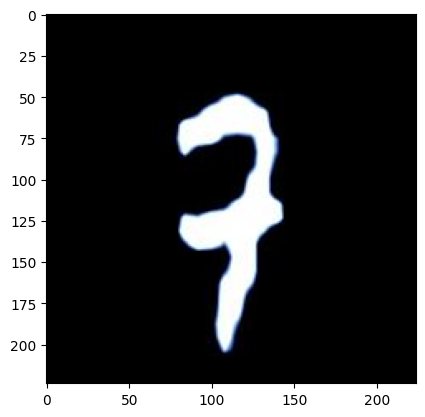

In [21]:
loader = LuxonisLoader(dataset)
for img, _ in loader:
    plt.imshow(img)
    plt.show()
    break

In [22]:
# Initialize the ONNX Runtime session for the model
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("./data/resnet50-1.onnx", providers=provider)

In [23]:
# Setup Weaviate
weaviate_api = WeaviateAPI("http://localhost:8080")

weaviate_api.create_collection(
    collection_name="Mnist_LDF", properties=["label", "image_path"]
)

Collection Mnist_LDF created.


In [24]:
# Load the LuxonisDataset
emb_dict = generate_embeddings(
    dataset, ort_session, weaviate_api, output_layer_name="/Flatten_output_0"
)

Upserted 6400 of embeddings to VectorDB.
Embeddings generation and insertion completed!


In [25]:
first_emb = None

# get a specific sample from dataset
first_sample = list(emb_dict.keys())[0]
first_emb = emb_dict[first_sample]
sample_id = first_sample

df = dataset._load_df_offline()
sample = df[df["instance_id"] == sample_id]
sample

,file,class,type,value,instance_id,value_type,created_at
0,mnist_0.jpg,5,classification,True,88549444-d4db-5f19-b25c-1a833b0933c5,bool,2024-02-06 11:43:39.480940


In [26]:
# Search for the nearest neighbors
search_uuids, scores = weaviate_api.search_similar_embeddings(first_emb, top_k=5)
payloads = weaviate_api.retrieve_payloads_by_ids(search_uuids, properties=["label"])

# Print the search results
for u, p, s in zip(search_uuids, payloads, scores):
    print(u, p["label"], s)

88549444-d4db-5f19-b25c-1a833b0933c5 5 1.0000004768371582
cd359adc-6ef5-55ff-a5eb-57bb32f63660 5 0.966323733329773
7b18f337-1f5a-5a21-95e8-45d4a5151956 3 0.9644825458526611
f810de5a-2da2-511d-9f3a-c1a7697c09a3 3 0.9641941785812378
a77bb5ea-fe98-5ef3-9797-57ab64d2b47c 3 0.9602988958358765


## ONNX, LuxonisFileSystem and Weaviate
Using the LuxonisFileSystem we can extract embeddings of pictures stored locally, on GCS or S3.

In [27]:
# file_info = {
#     "base_path": "gcs-bucket-name",
#     "prefix": "path/to/dataset",
#     "model_path": "path/to/model.onnx",
# }

In [28]:
# lfs = LuxonisFileSystem("gs://" + file_info["base_path"])

# local_model = "./emb_model.onnx"
# lfs.get_file(file_info["model_path"], local_model)

In [29]:
current_dir = os.getcwd()
file_info = {
    "base_path": current_dir,
    "prefix": "data/mnist_images_w",
    "model_path": "data/resnet50-1.onnx",
}
local_model = file_info["model_path"]

In [30]:
# Initialize the ONNX Runtime session for the model
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession(local_model, providers=provider)

In [31]:
lfs_local = LuxonisFileSystem(file_info["base_path"])

In [32]:
files = []
for i, f in enumerate(lfs_local.walk_dir(file_info["prefix"])):
    if f.endswith(".png") or f.endswith(".jpg"):
        files.append(f)
    if i > 100:
        break

In [33]:
# testing image conversion errors
files.append(file_info["prefix"] + "/non_existing_file.jpg")

In [34]:
embeddings, succ_ix = extract_embeddings(
    files,
    ort_session,
    lfs_local,
    preprocess_function=None,  # uses the default preprocessing function
    output_layer_name="/Flatten_output_0",
    batch_size=64,
)

Error occurred while processing image: data/mnist_images_w/non_existing_file.jpg, Error: [Errno 2] No such file or directory: '/home/drew99/Luxonis-work/workspace/luxonis-ml/examples/data/mnist_images_w/non_existing_file.jpg'


In [35]:
len(succ_ix), len(embeddings), len(files)
# assert len(embeddings) == len(succ_ix)
# assert len(embeddings) == len(files)
# assert len(succ_ix) == len(files)

(102, 102, 103)

In [36]:
# print the failed files
for i in range(len(files)):
    if i not in succ_ix:
        print(files[i])

data/mnist_images_w/non_existing_file.jpg


In [37]:
# Setup Weaviate
weaviate_api = WeaviateAPI("http://localhost:8080")
weaviate_api.create_collection(collection_name="Mnist_LFS", properties=["image_path"])

Collection Mnist_LFS created.


In [38]:
uuids = [str(uuid.uuid4()) for _ in range(len(embeddings))]
payloads = [{"image_path": f} for f in files]

In [39]:
weaviate_api.insert_embeddings(uuids, embeddings, payloads, batch_size=50)

In [40]:
# Search for the nearest neighbors
search_uuids, scores = weaviate_api.search_similar_embeddings(embeddings[0], top_k=5)

# Print the search results
for u, s in zip(search_uuids, scores):
    print(u, s)

aa316046-c008-4308-9079-1bc4e2854454 1.0000005960464478
45b8a24c-db17-4784-b492-cdb6eaa4164f 0.9511607885360718
c95096d9-2f99-4a49-97cc-46be525c05c7 0.9434914588928223
a5422f18-48ac-4d69-8dcd-973669c20de8 0.9433823227882385
ab0f61ef-451f-4392-82be-b41a50787317 0.9373813271522522


## Embeddings Processing

In [41]:
# look at the Embeddings_Processing_Example.ipynb for the rest of the code

## Remove everything

In [42]:
# ! rm -rf data

In [43]:
# # Delete the collection
# weaviate_api = WeaviateAPI("http://localhost:8080")
# weaviate_api.create_collection(collection_name="Mnist_LDF")
# weaviate_api.delete_collection()

In [44]:
# # Delete the Luxonis ML dataset
# dataset_name = "Mnist_LDF_W"
# dataset = LuxonisDataset(dataset_name)
# dataset.delete_dataset()